In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.metrics import (
    precision_score, recall_score,
    f1_score, confusion_matrix, cohen_kappa_score
)
import matplotlib.pyplot as plt
import numpy as np

In [6]:
class SymptomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        
        self.texts = df['Symptoms'].apply(
            lambda lst: ' '.join(lst) if isinstance(lst, list) else str(lst)
        ).tolist()
        
        self.label_categories = pd.Categorical(df['Disease'])
        self.labels = self.label_categories.codes
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': enc.input_ids.squeeze(0),
            'attention_mask': enc.attention_mask.squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [7]:
def train_text_model(csv_path, checkpoint_path, batch_size=16, lr=2e-5, epochs=10):
    
    df = pd.read_csv(csv_path)
    num_labels = df['Disease'].nunique()

    
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    dataset = SymptomDataset(df, tokenizer)

    
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,       
        pin_memory=True      
    )
    eval_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=num_labels
    ).to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=lr)

    
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_corrects = 0

        for batch in loader:
            optim.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            loss = outputs.loss
            loss.backward()
            optim.step()

            total_loss += loss.item() * batch['input_ids'].size(0)
            preds = outputs.logits.argmax(dim=1)
            total_corrects += (preds == batch['labels'].to(device)).sum().item()

        epoch_loss = total_loss / len(dataset)
        epoch_acc = total_corrects / len(dataset)
        print(f"Epoch {epoch+1}/{epochs} — Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in eval_loader:
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )
            preds = outputs.logits.argmax(dim=1).cpu().numpy()
            labels = batch['labels'].numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall    = recall_score(all_labels, all_preds, average='weighted')
    f1        = f1_score(all_labels, all_preds, average='weighted')
    kappa     = cohen_kappa_score(all_labels, all_preds)
    cm        = confusion_matrix(all_labels, all_preds)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"Kappa:     {kappa:.4f}")

    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(dataset.label_categories.categories))
    plt.xticks(tick_marks, dataset.label_categories.categories, rotation=45, ha='right')
    plt.yticks(tick_marks, dataset.label_categories.categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Saved text model to {checkpoint_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 — Loss: 1.2013, Accuracy: 0.8196
Epoch 2/10 — Loss: 0.1066, Accuracy: 0.9984
Epoch 3/10 — Loss: 0.0429, Accuracy: 0.9988
Epoch 4/10 — Loss: 0.0255, Accuracy: 0.9984
Epoch 5/10 — Loss: 0.0174, Accuracy: 0.9986
Epoch 6/10 — Loss: 0.0129, Accuracy: 0.9984
Epoch 7/10 — Loss: 0.0275, Accuracy: 0.9950
Epoch 8/10 — Loss: 0.0227, Accuracy: 0.9946
Epoch 9/10 — Loss: 0.0072, Accuracy: 0.9992
Epoch 10/10 — Loss: 0.0057, Accuracy: 0.9986
Precision: 0.9988
Recall:    0.9988
F1-score:  0.9988
Kappa:     0.9987


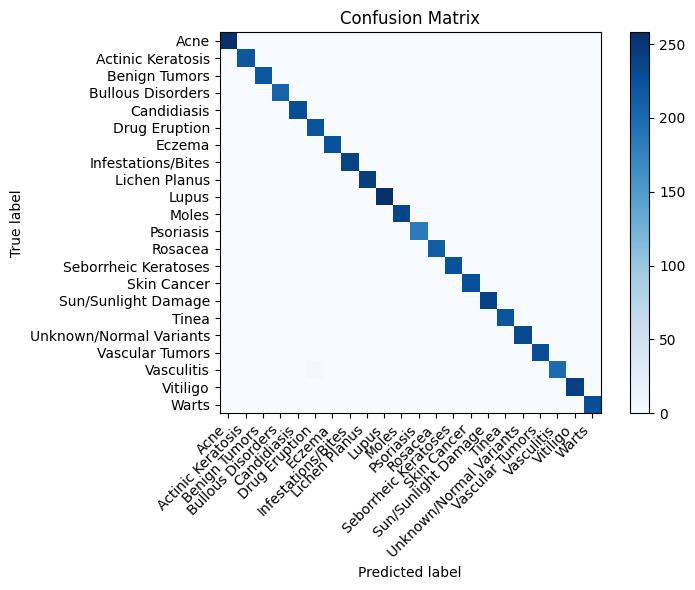

Saved text model to C:/Users/trafl/Desktop/Minor/Model/text_model.pth


In [ ]:
if __name__ == "__main__":
    
    csv_path  = r"Dataset/Text-based/skin_disease_symptoms_dataset.csv"
    ckpt_path = r"text_model.pth"
    train_text_model(csv_path, ckpt_path)